In [1]:
!pwd

/home/alan_khang/adam_sandbox


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
import time
from scipy.spatial.transform import Rotation as R
import math

In [2]:
intr = np.array([
    [1153.5057993547039, 0.0, 935.6792059488656],
    [0.0, 1153.5057993547039, 542.5244050874031],
    [0.0, 0.0, 1.0]
])

dist_coff = np.array([
    9.885010653342695,
    12.795985683057348,
    -0.0002764906680794237,
    0.0008323723464815434,
    -1.7568760193035896,
    9.875338536721655,
    15.944870272899509,
    -0.5682433636832124
])

correct_rot_mat = np.array([
    [0., 1., 0.],
    [-1., 0., 0.],
    [0., 0., 1.]
])

In [3]:
img = cv2.imread('/home/alan_khang/Downloads/captured_images/captured_image_52.jpg')

#img = cv2.undistort(img, cameraMatrix=intr, distCoeffs=dist_coff)

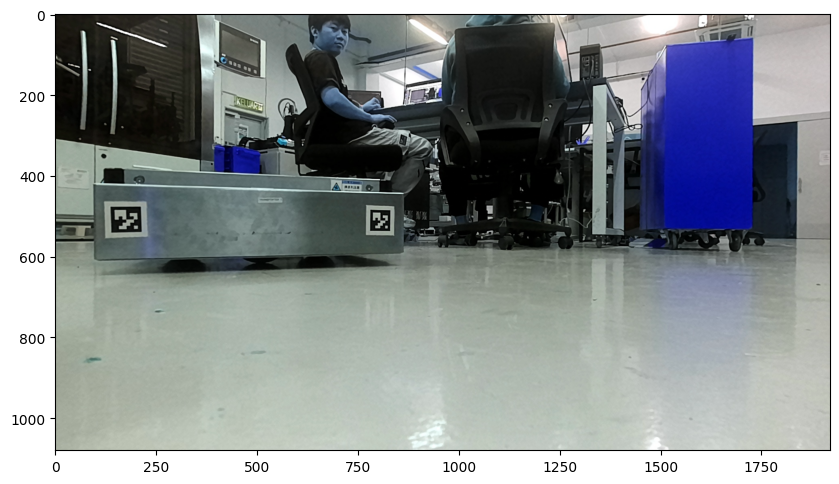

In [4]:
_ = plt.figure(figsize=(10, 10))
plt.imshow(img)

In [5]:
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
parameters = cv2.aruco.DetectorParameters()
ar_detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

In [6]:
original_h, original_w = img.shape[:2]
original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

zoom_factor = 1
resized_w = int(original_w * zoom_factor)
resized_h = int(original_h * zoom_factor)
resized_gray = cv2.resize(original_gray, (resized_w, resized_h))

start_time = time.time()

corners, ids, _ = ar_detector.detectMarkers(resized_gray)

end_time = time.time()

In [7]:
processed_time = end_time - start_time

In [8]:
boxes = []
centers = []
target_marker_ids = [0]

scale_factor = 1 / zoom_factor
if corners is not None:
    corners = [corner * scale_factor for corner in corners]

for i, marker_id in enumerate(ids.flatten()):
    if marker_id in target_marker_ids:
        x_coords = corners[i][0][:, 0]
        y_coords = corners[i][0][:, 1]
        x1, y1 = int(np.min(x_coords)), int(np.min(y_coords))
        x2, y2 = int(np.max(x_coords)), int(np.max(y_coords))
        center = ((x1+x2)//2, (y1+y2)//2)
        boxes.append(((x1, y1, x2, y2), f'ArUco_{marker_id}', 1.0))
        centers.append(center)

In [9]:
aruco_boxes, aruco_centers = boxes, centers
num_markers = len(aruco_centers)

sum_x = sum(c[0] for c in aruco_centers)
sum_y = sum(c[1] for c in aruco_centers)
midpoint = (sum_x // num_markers, sum_y // num_markers)

In [10]:
def _calculate_object_shift_mm(midpoint, depth_mm, image_center, h_fov_deg=69.4):

    x_shift_px = midpoint[0] - image_center[0]
    y_shift_px = midpoint[1] - image_center[1]

    fx = image_center[0] / math.tan(math.radians(h_fov_deg / 2))  # focal length in pixels
        
    x_shift_mm = (x_shift_px * depth_mm) / fx
    y_shift_mm = (y_shift_px * depth_mm) / fx  # assuming square pixels

    return (x_shift_mm, y_shift_mm)

def _draw_crosshair(image, center, color, size=10, thickness=2):
    x, y = map(int, center)
    cv2.line(image, (x - size, y), (x + size, y), color, thickness)
    cv2.line(image, (x, y - size), (x, y + size), color, thickness)

    return image

In [11]:
device_midpoint = tuple(midpoint)

In [12]:
annotated_img = img.copy()
annotated_img = _draw_crosshair(annotated_img, midpoint, (0, 0, 255), size=30, thickness=5)

image_center = (annotated_img.shape[1]//2, annotated_img.shape[0]//2)
annotated_img = _draw_crosshair(annotated_img, image_center, (0, 255, 255), size=30, thickness=5)

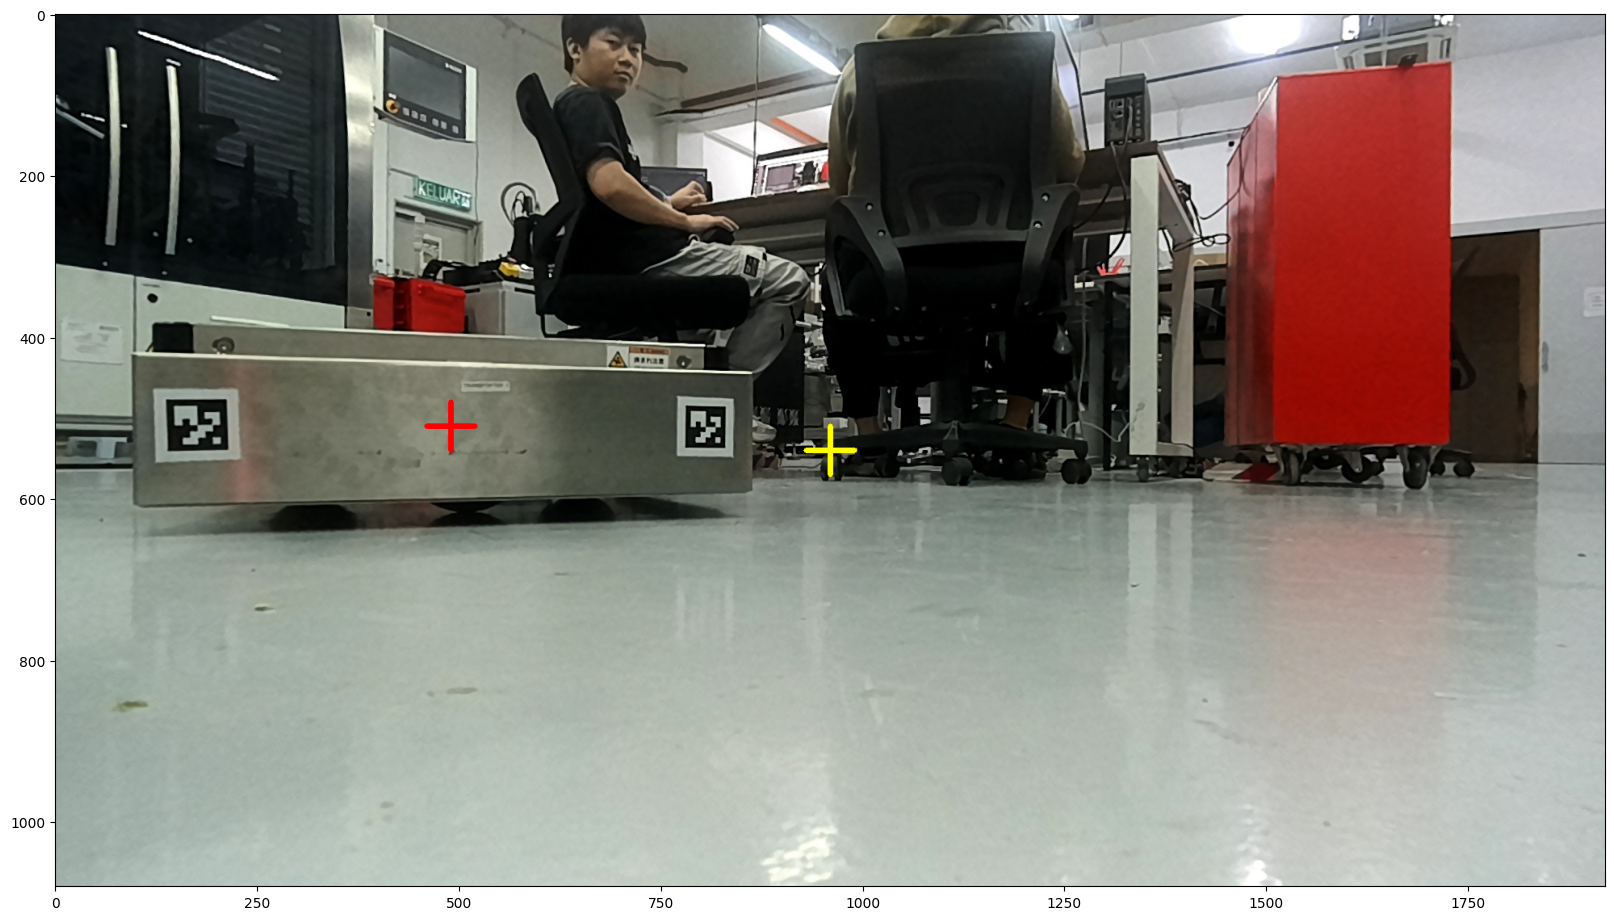

In [13]:
_ = plt.figure(figsize=(20, 20))
plt.imshow(annotated_img[..., ::-1])  # Convert BGR to RGB for display

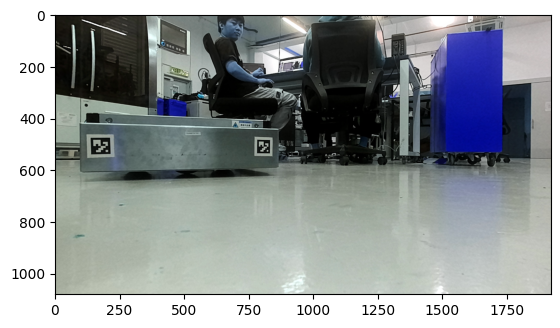

In [14]:
img = cv2.imread('/home/alan_khang/Downloads/captured_images/captured_image_52.jpg')
plt.imshow(img)

In [15]:
ARUCO_DICT = {
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

In [18]:
def detect_markers(image, aruco_ids):
    
    aruco_type_list = []
    
    for aruco_type, dictionary_id in ARUCO_DICT.items():

        arucoDict = cv2.aruco.getPredefinedDictionary(dictionary_id)
        arucoParams = cv2.aruco.DetectorParameters()

        corners, ids, _ = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        if len(corners) and ids is not None and len(ids):
            for corner, id in zip(corners, ids.flatten()):
                if id in aruco_ids:
                    aruco_type_list.append(aruco_type)
            
    return aruco_type_list

def pose_estimation(frame, aruco_dict_type, matrix_coefficients, distortion_coefficients, marker_size):

    rvecs, tvecs = [], [] 
    aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)
    parameters = cv2.aruco.DetectorParameters()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejected = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if len(corners) > 0:
        for i in range(0, len(ids)):

            print('******')
            print(corners[i])
           
            rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], marker_size, matrix_coefficients, distortion_coefficients)
            r_mat, _ = cv2.Rodrigues(rvec)

            # The aruko in this scenario is rotated about z-axis, we need to adjust the rotation matrix
            r_mat_correct = r_mat @ correct_rot_mat
            #r_mat_correct = z_rot_mat_90_deg @ r_mat
            r_vec_correct, _ = cv2.Rodrigues(r_mat_correct)

            rvecs.append(r_vec_correct)
            tvecs.append(tvec)
            
            cv2.aruco.drawDetectedMarkers(frame, corners) 

            cv2.drawFrameAxes(
                frame, 
                matrix_coefficients, 
                distortion_coefficients, 
                r_vec_correct, 
                tvec, 
                0.06
            ) 
             
    return frame, rvecs, tvecs

In [19]:
obj = 'guilder'
marker_size = 0.037 if obj == 'guilder' else 0.041

processed_img = np.ascontiguousarray(img.copy())
aruco_ids = [0]
gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
rvecs, tvecs = [], []

for aruco_type in detect_markers(gray, aruco_ids):
    processed_img, rvec, tvec = pose_estimation(processed_img, ARUCO_DICT[aruco_type], intr, np.zeros(8, dtype=np.float64), marker_size)
    rvecs.extend(rvec)
    tvecs.extend(tvec)

******
[[[780. 536.]
  [781. 485.]
  [830. 486.]
  [829. 537.]]]
******
[[[140. 541.]
  [137. 478.]
  [211. 477.]
  [214. 539.]]]


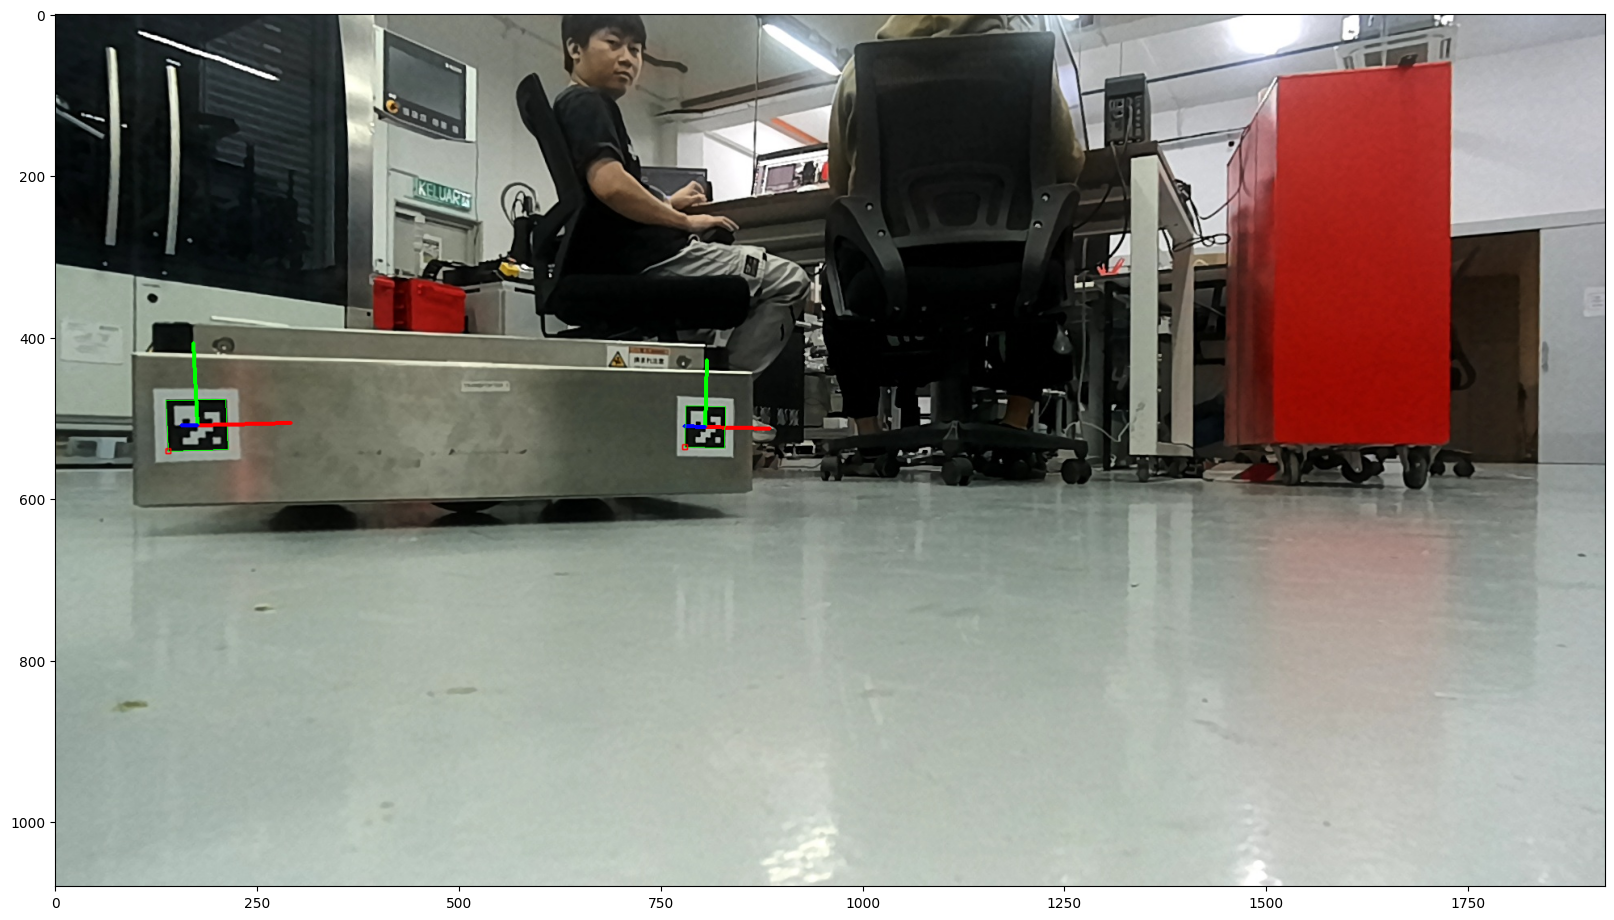

In [20]:
_ = plt.figure(figsize=(20, 20))
plt.imshow(processed_img[..., ::-1])

In [19]:
tvec1, tvec2 = tvecs[0], tvecs[1]
rvec1, rvec2 = rvecs[0], rvecs[1]

#rvec1 = rvec1 * -1
#rvec2 = rvec2 * -1

t_mid = (tvec1 + tvec2) / 2

R1, _ = cv2.Rodrigues(rvec1)
R2, _ = cv2.Rodrigues(rvec2)

# Simple average of the matrices (not strictly valid but reasonable for nearby rotations)
R_mid = (R1 + R2) / 2.0

# Re-orthonormalize the result (optional but better for accuracy)
U, _, Vt = np.linalg.svd(R_mid)
R_mid = U @ Vt

# Convert back to rvec
rvec_mid, _ = cv2.Rodrigues(R_mid)

In [20]:
processed_img = cv2.drawFrameAxes(processed_img, intr, np.zeros(8, dtype=np.float64), rvec_mid, t_mid, 0.06) 

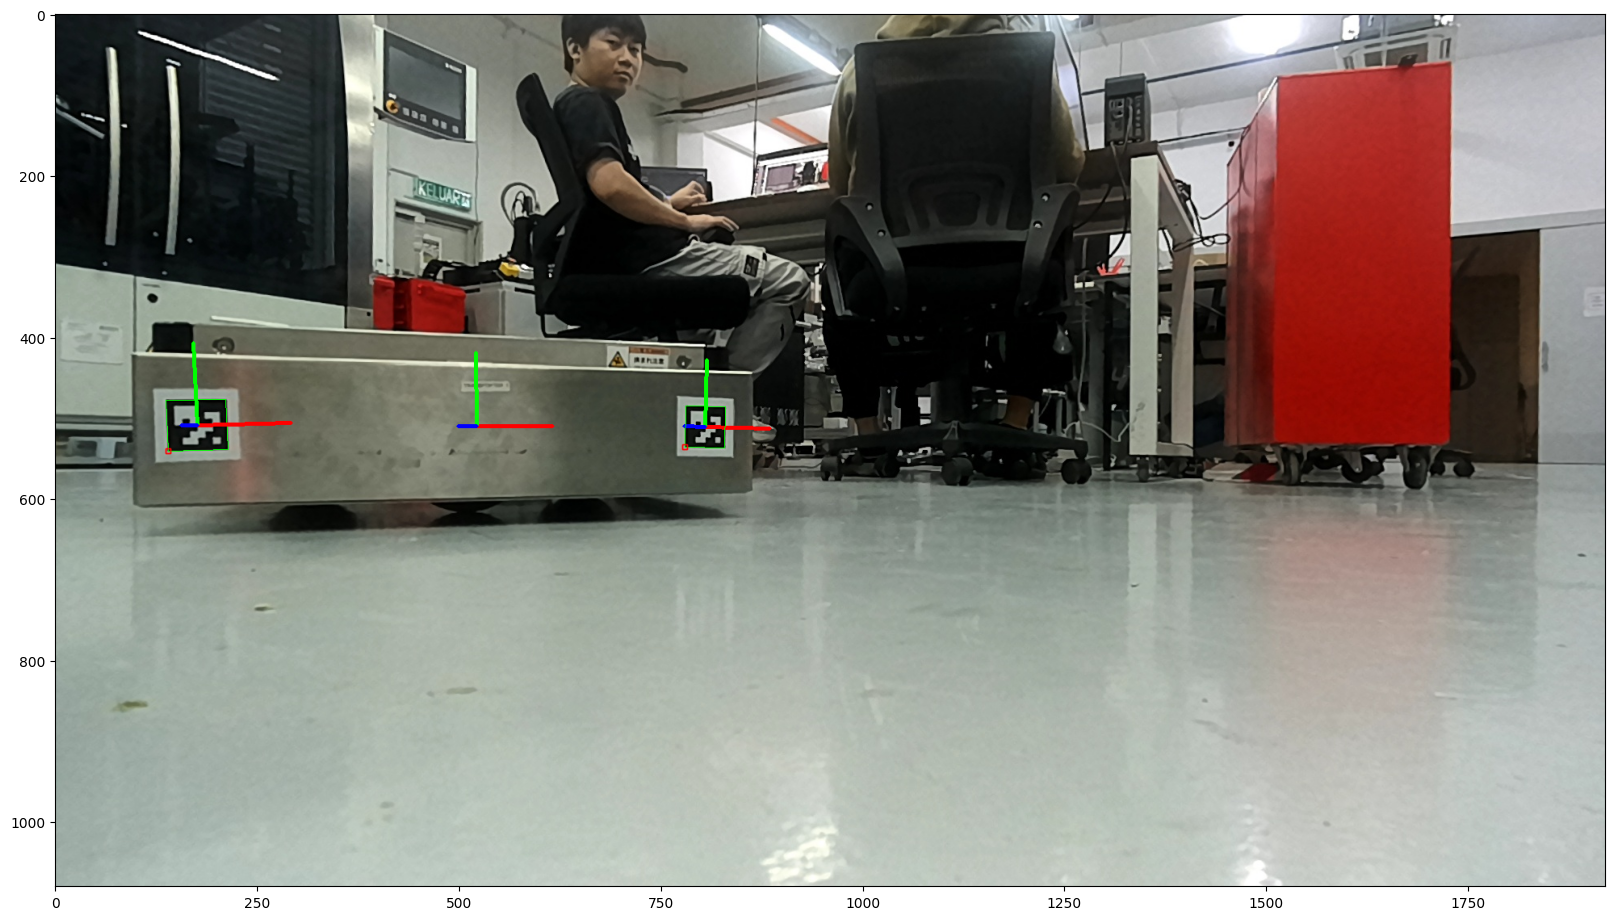

In [21]:
_ = plt.figure(figsize=(20, 20))
plt.imshow(processed_img[..., ::-1])

In [22]:
processed_img = cv2.drawFrameAxes(
    processed_img, 
    cameraMatrix=intr, 
    distCoeffs=np.zeros(8, dtype=np.float64), 
    rvec=cv2.Rodrigues(np.eye(3))[0], 
    tvec=np.array([0, 0, 1], dtype=np.float64),
    length=0.06
) 

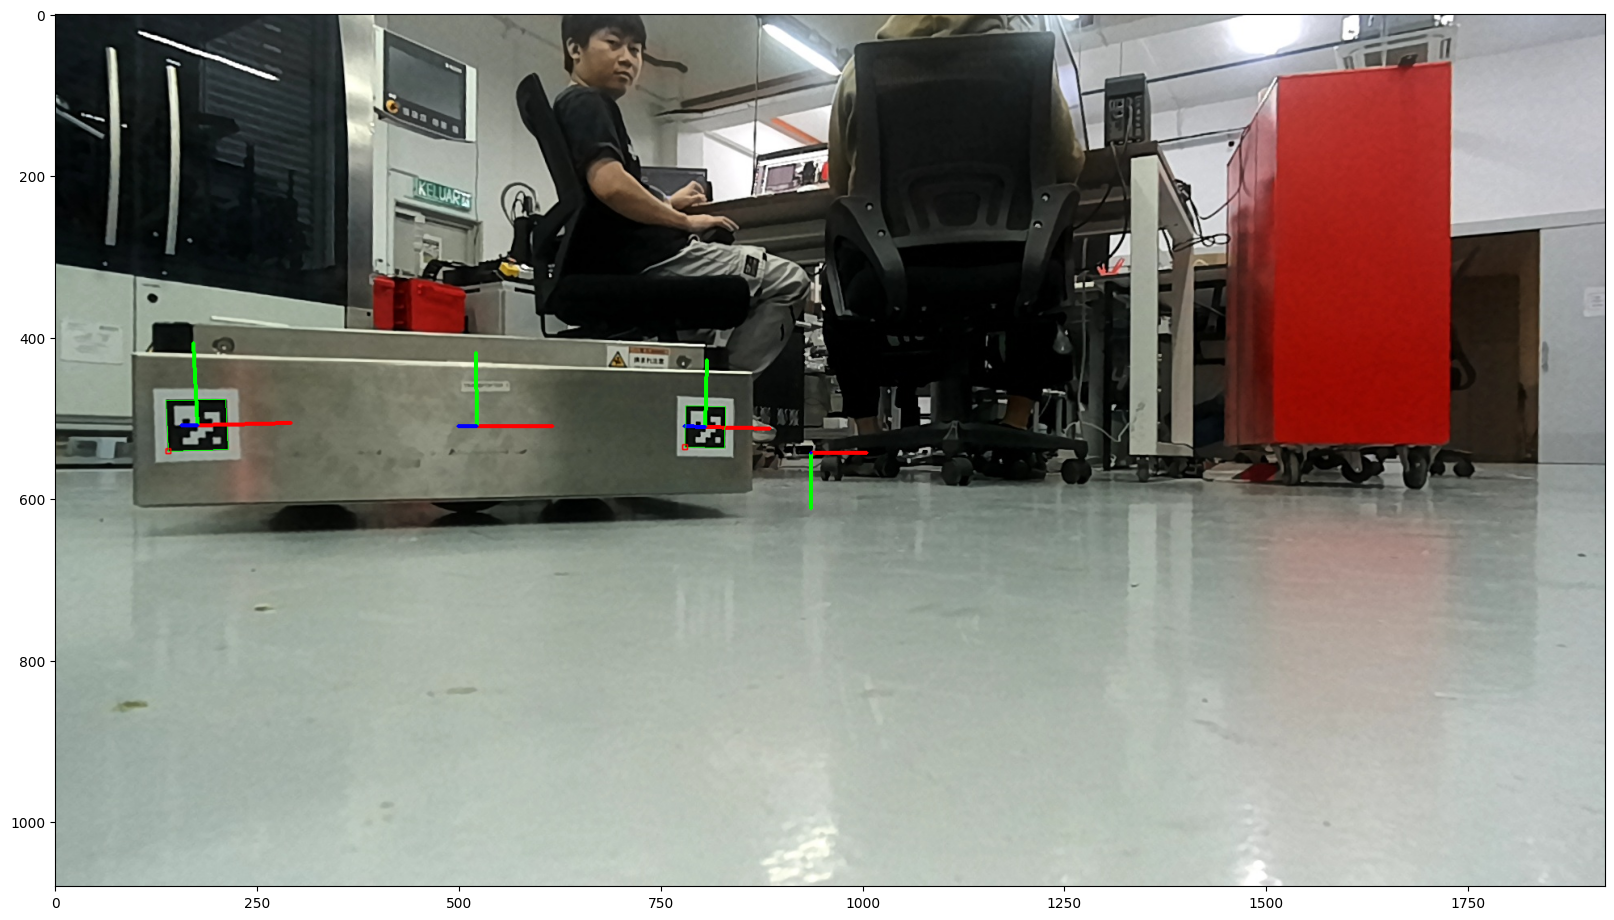

In [23]:
plt.figure(figsize=(20, 20))

plt.imshow(processed_img[..., ::-1])

In [24]:
rvec_mid 

array([[-3.11151851],
       [ 0.00568306],
       [-0.19179828]])

In [25]:
def rotationMatrixToEulerAngles(R):
    """
    Convert a rotation matrix to Euler angles (roll, pitch, yaw).
    """
    assert (R.shape == (3, 3))
    
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    
    singular = sy < 1e-6
    
    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0
    
    return np.array([x, y, z])

In [26]:
rmat_mid, _ = cv2.Rodrigues(rvec_mid)
euler_angles = rotationMatrixToEulerAngles(rmat_mid)

In [27]:
np.rad2deg(euler_angles)[1]

-7.0510537440456815

In [28]:
R1

array([[ 0.98244791,  0.02167934, -0.18527308],
       [ 0.02465985, -0.99960068,  0.01379768],
       [-0.18489998, -0.01812431, -0.9825902 ]])

In [29]:
R2

array([[ 0.90750265, -0.02295677,  0.41941857],
       [-0.03656202, -0.99903278,  0.02442803],
       [ 0.41845211, -0.03750329, -0.90746424]])

In [30]:
R_rel = R1 @ R2.T

In [31]:
angle = np.arccos((np.trace(R_rel) - 1) / 2)

In [32]:
angle

0.6211563207838366

In [33]:
angle_threshold = np.deg2rad(5)

In [34]:
angle_threshold

0.08726646259971647

In [35]:
rmat_mid

array([[ 0.99242393, -0.00215206,  0.1228418 ],
       [-0.00512503, -0.99970144,  0.02389077],
       [ 0.12275371, -0.02433934, -0.99213866]])

In [36]:
t_mid

array([[[-0.27229927, -0.02142552,  0.75997285]]])

In [37]:
R = np.eye(4)
R[:3, :3] = rmat_mid
R[:3, 3] = t_mid.flatten()
R

array([[ 0.99242393, -0.00215206,  0.1228418 , -0.27229927],
       [-0.00512503, -0.99970144,  0.02389077, -0.02142552],
       [ 0.12275371, -0.02433934, -0.99213866,  0.75997285],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [29]:
object_center = intr @ t_mid.squeeze().reshape(3, 1)
object_center_2d = object_center / object_center[2]  # Normalize by the third coordinate
object_center_2d = object_center_2d[:2].flatten()

In [30]:
img_center = intr @ np.array([[0], [0], [1]])
img_center_2d = img_center.squeeze() / img_center[2]  # Normalize by the third coordinate
img_center_2d = img_center_2d[:2]

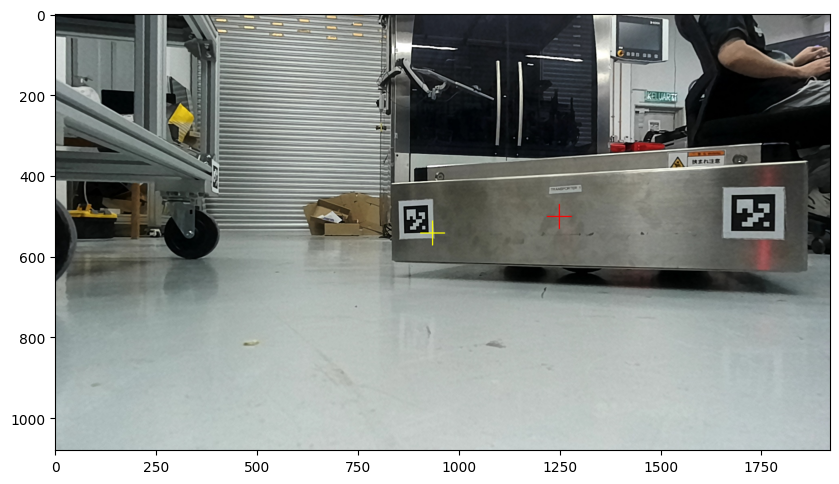

In [31]:
crosshair_img = img.copy()
crosshair_img = _draw_crosshair(crosshair_img, object_center_2d, (0, 0, 255), size=30, thickness=2)
crosshair_img = _draw_crosshair(crosshair_img, img_center_2d, (0, 255, 255), size=30, thickness=2)

plt.figure(figsize=(10, 10))
plt.imshow(crosshair_img[..., ::-1])

In [32]:
def angle_between_points(p1, p2):
    dx = np.abs(p2[0] - p1[0])
    dy = np.abs(p2[1] - p1[1])
    theta = math.atan2(dy, dx)  # in radians
    angle_deg = math.degrees(theta)
    return angle_deg


In [33]:
angle = angle_between_points(img_center_2d, object_center_2d)

In [34]:
t_mid_mm = t_mid.squeeze() * 1000  # Convert to mm
x_shift_mm = t_mid_mm[0]  # X shift in mm
y_shift_mm = t_mid_mm[1]  # Y shift in mm
depth = t_mid_mm[2]  # Depth in mm

In [35]:
text_lines = [
    f"Depth: {depth:.1f} mm",
    f"Angle: {angle:.1f} deg",
    f"Shift: ({x_shift_mm:.1f}, {y_shift_mm:.1f}) mm"
]
        
y_offset = 40
for line in text_lines:
    text_size = cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
    cv2.putText(crosshair_img, line, 
            (int(img_center_2d[0]), int(img_center_2d[1]-y_offset)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    y_offset += text_size[1] + 10

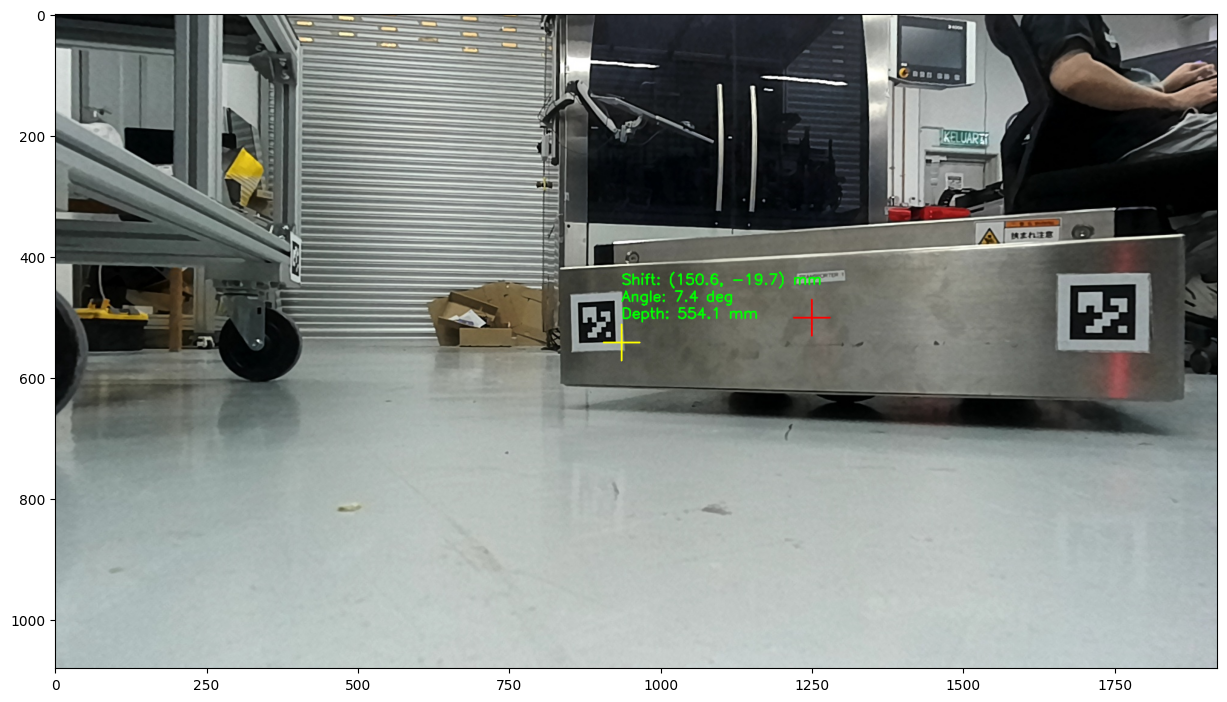

In [36]:
plt.figure(figsize=(15, 15))
plt.imshow(crosshair_img[..., ::-1])

In [37]:
object_center_2d[0]

1249.156029670015

In [38]:
float(rvec_mid[-1])

-0.6393167014126638

In [4]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread("/home/alan_khang/Downloads/18_31_55/depth/t1_frame_0000031.png", cv2.IMREAD_UNCHANGED)
img = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=0.03), cv2.COLORMAP_JET)

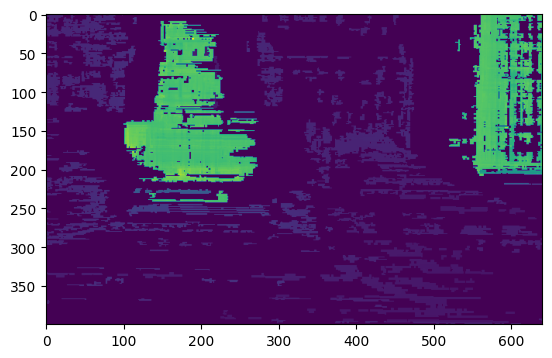

In [12]:
plt.imshow(img)